In [1]:
import sys
sys.path.insert(0, "../..")

import jax
import jax.numpy as jnp

from tqdm import tqdm
from functools import partial

import module.samplers
import module.hamiltonians
import module.wavefunctions

import flax.linen as nn

import optax
import numpy as np
from matplotlib import pyplot as plt

In [2]:
key = jax.random.PRNGKey(0)

In [3]:
#
# The potential energy function depending on the coordinates
#
def potential(x):
    return -jnp.sqrt(2)/jnp.sqrt(jnp.sum(x**2, axis = -1))


# the hamiltonian
H = module.hamiltonians.Particles(masses = [1], potential = potential, d_space = 3)

The wavefunction is parametrised with a bounded nerual network and a decaying gaussian envelope to ensure normalisability.

$$
\log{\Psi} = a \cdot \mathrm{sigmoid}(\mathrm{NN}(\vec{r})) - \frac{r^2}{b^2}
$$

The coefficients $a$ and $b$ have to be chosen or could be trained.

In [4]:
def sigmoid(x):
    return 1/(1 + jnp.exp(-x))

In [5]:
class NN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(40, name="dense1")(x)
        x = nn.relu(x)
        x = nn.Dense(1, name="dense2")(x)
        return sigmoid(x)

In [6]:
class Orbital(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__((3,))
        self.nn = NN()

    def init_parameters(self, key):
        nn_param = self.nn.init(key, jnp.empty((3,)))
        scale = jnp.array(10.)
        return {"nn": nn_param, "scale": scale}
    
    def calc_logpsi(self, parameters, x):
        r = jnp.sqrt(jnp.sum(x**2, axis = -1))
        return -jnp.squeeze(self.nn.apply(parameters["nn"], x))*parameters["scale"] - r**2/5**2 

In [7]:
wavefun = Orbital()
parameters = wavefun.init_parameters(key)

## Inspect the Wavefunction

We take straight lines through the origin at radom angles and plot the wavefunction along it.

Text(0.5, 1.0, 'Radial Wavefunction')

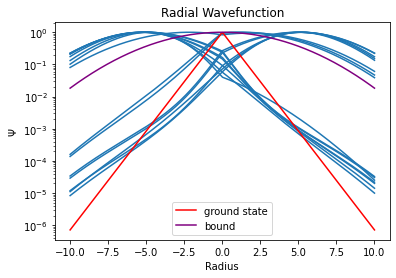

In [8]:
def getLine(phi, theta, r_max = 10):
    r = jnp.linspace(-r_max, r_max, num = 2000)
    x = jnp.cos(phi)*jnp.sin(theta) * r
    y = jnp.sin(phi)*jnp.sin(theta) * r
    z = jnp.cos(theta) * r

    return r, jnp.stack((x,y,z), axis = 1)

getLine = jax.vmap(getLine, in_axes=[0,0])

phi = jax.random.uniform(key, shape = (15,)) * 2 * jnp.pi
theta = jax.random.uniform(key, shape = (15,)) * jnp.pi

r, line = getLine(phi,theta)

for i in range(15):
    prob = wavefun.calc_logpsi(parameters, line[i])
    plt.plot(r[i], jnp.exp(prob)/jnp.max(jnp.exp(prob)), color = "C0")


s = np.linspace(-10,10, num = 500)
plt.plot(s, jnp.exp(-jnp.abs(s)*jnp.sqrt(2)), color = "red", label = "ground state")
plt.plot(s, jnp.exp(-s**2/5**2), color = "purple", label = "bound")

plt.yscale("log")

plt.legend()

plt.xlabel("Radius")
plt.ylabel("$\\Psi$")

plt.title("Radial Wavefunction")


Text(0.5, 1.0, 'wavefunction at z = 0')

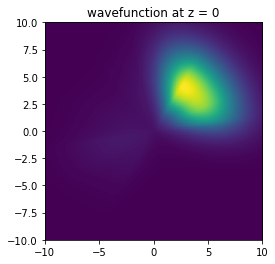

In [9]:
n = 100
x, y = jnp.meshgrid(jnp.linspace(-10,10, num = n), jnp.linspace(-10,10, num = n))
z = jnp.ones_like(x) * 0
im_coord = jnp.stack((x,y,z), axis = -1)
coords = jnp.reshape(im_coord, (-1, 3))
im = wavefun.calc_psi(parameters, coords).reshape(x.shape)
plt.imshow(im, extent = [-10,10,-10,10])

plt.title("wavefunction at z = 0")

## Initialise a MC-Sampler

In [10]:
sampler = module.samplers.MCMC(wavefun, variance = 0.6)

In [11]:
N = 50000
samples, ratio = sampler.sample(key, parameters, jax.random.normal(key, (3,)), N)
H_loc = H.calc_H_loc(wavefun, parameters, samples)

print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc))
print("Std of Expected Energy:", jnp.std(H_loc)/jnp.sqrt(N))
print("Energy Error in units of MC deviation:", jnp.abs(jnp.mean(H_loc) + 1)/jnp.std(H_loc)*jnp.sqrt(N))

Acceptance Ratio: 0.73539996
Expected Energy: -0.16139348
Std of Expected Energy: 0.0007131577
Energy Error in units of MC deviation: 1175.9062


### Figure out the decorrelation-time

(0.0, 50.0)

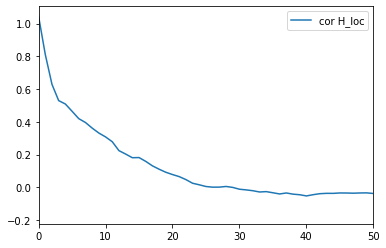

In [12]:
plt.plot(jnp.correlate(H_loc-jnp.mean(H_loc), H_loc[0:2000])/jnp.std(H_loc[0:2000])**2/2000, label = "cor H_loc")
plt.legend()
plt.xlim(0,50)

In [13]:
## subsample by factor

ss_factor = 30

subsamples = samples[0:-1:ss_factor]

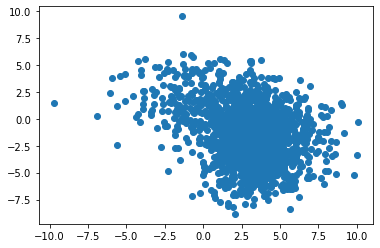

In [14]:
plt.scatter(subsamples[:, 0], subsamples[:, 1])

To estimate the gradient of the expected energy via the formula:

$$
\nabla \left< E \right>  = 2\,\Re\, \mathbb{E}\{\nabla \log \Psi [H_{\mathrm{loc}}(r) - \mathbb{E}(E)]\}
$$

we implement a help function:

In [15]:
@partial(jax.jit, static_argnames=['hamiltonian', 'orbital'])
def calc_grad_E(hamiltonian, orbital, parameters, samples):
    """
    Calculates the gradient of the energy and the energy itself on a batch of samples.
    """

    E_loc = hamiltonian.calc_H_loc(orbital, parameters, samples)
    E = jnp.mean(E_loc)
    dE = jnp.std(E_loc)
    grad_log = orbital.grad_logpsi(parameters, samples)

    return jax.tree_util.tree_map(lambda tree: 2*jnp.real(jnp.mean(jnp.swapaxes(jnp.swapaxes(tree, 0, -1) * (E_loc - E), 0, -1), axis = 0)), grad_log), E, dE

The energy can now be optimised:

In [16]:
Es_ = []
dEs_ = []
ratios_ = []

In [23]:
N = 4000

# define
optimizer = optax.adam(learning_rate=0.005)

# initialise
optimizer_state = optimizer.init(parameters)

for i in tqdm(range(200)):
    key, _ = jax.random.split(key)
    samples, ratio = sampler.sample(key, parameters, jax.random.normal(key, (3,)), N*ss_factor)
    samples = samples[0:-1:ss_factor]
    grad, E, dE = calc_grad_E(H, wavefun, parameters, samples)

    Es_.append(E)
    dEs_.append(dE)
    ratios_.append(ratio)
    
    updates, optimizer_state = optimizer.update(grad, optimizer_state, parameters)

    parameters = optax.apply_updates(parameters, updates)

Es = np.array(Es_)
dEs = np.array(dEs_) / np.sqrt(N)
ratios = np.array(ratios_)

100%|██████████| 200/200 [00:14<00:00, 14.15it/s]


Text(0.5, 1.0, 'Energy Optimisation')

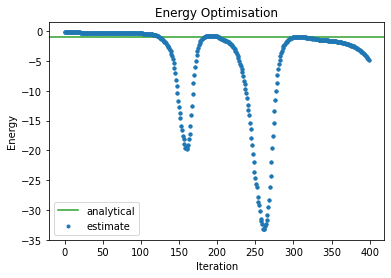

In [24]:
index = np.arange(Es.shape[0])

plt.scatter(index, Es, label = "estimate", marker = ".")
# plt.fill_between(index, Es - dEs, Es + dEs, alpha = 0.7, label = "$\\pm \\sigma$", color = "C3")
plt.errorbar(index, Es, yerr = dEs, fmt = ".")
# plt.ylim(-1.5,0.5)
# plt.xlim(200,300)
plt.axhline(-1, color = "C2", label = "analytical")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Energy Optimisation")

Text(0.5, 1.0, 'Energy Optimisation')

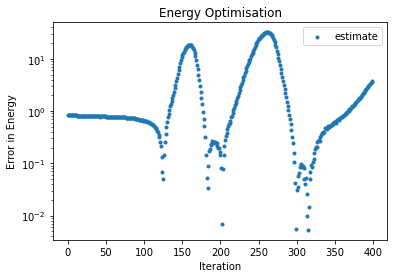

In [25]:
index = np.arange(Es.shape[0])

# plt.errorbar(index, np.abs(Es + 1), yerr = dEs, label = "estimate", fmt = ".")
plt.scatter(index, np.abs(Es + 1), label = "estimate", marker = ".")
# plt.fill_between(index, Es - dEs, Es + dEs, alpha = 0.4, label = "$\\pm \\sigma$")
# plt.ylim(-2,2)
# plt.axhline(-1, color = "C2", label = "analytical")
plt.yscale("log")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Error in Energy")
plt.title("Energy Optimisation")

Now, the variance of the expected energy has decreased, as expected for correct eigenstate:

In [26]:
N = 12000
samples, ratio = sampler.sample(key, parameters, jax.random.normal(key, (3,)), N*ss_factor)
samples = samples[0:-1:ss_factor]
V_loc = H.calc_V_loc(wavefun, parameters, samples)
T_loc = H.calc_T_loc(wavefun, parameters, samples)
H_loc = H.calc_H_loc(wavefun, parameters, samples)

print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc))
print("Std of Expected Energy:", jnp.std(H_loc)/jnp.sqrt(N))
print("Energy Error in units of MC deviation:", jnp.abs(jnp.mean(H_loc) + 1)/jnp.std(H_loc)*jnp.sqrt(N))

Acceptance Ratio: 0.16628334
Expected Energy: -4.9391418
Std of Expected Energy: 0.022036815
Energy Error in units of MC deviation: 178.75276


## Oberservation

Applying the kinectic Energy operator to the correct wavefunction, one obtains:

$$
T \Psi = \left(\frac{2\lambda}{r} +\lambda^2\right)\Psi
$$

The NN Ansatz allows only for continuously differentiable functions since a proper activation function was used. The Kato-cusp can hence not be reproduced, but the energy calculation is still valid, as the the laplacian can be calculated.

Text(0.5, 1.0, 'Local Potential Energy')

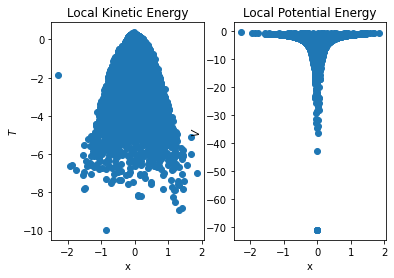

In [27]:
f, axs = plt.subplots(1, 2)

axs[0].scatter(samples[:,0], T_loc)
axs[0].set_xlabel("x")
axs[0].set_ylabel("$T$")
axs[0].set_title("Local Kinetic Energy")

axs[1].scatter(samples[:,0], V_loc)
axs[1].set_xlabel("x")
axs[1].set_ylabel("$V$")
axs[1].set_title("Local Potential Energy")

Text(0.5, 1.0, 'Radial Wavefunction')

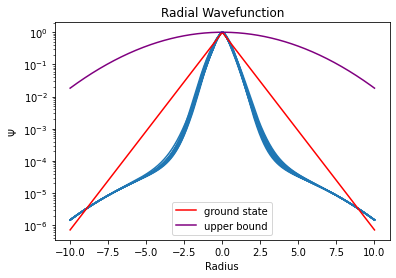

In [28]:
def getLine(phi, theta, r_max = 10):
    r = jnp.linspace(-r_max, r_max, num = 2000)
    x = jnp.cos(phi)*jnp.sin(theta) * r
    y = jnp.sin(phi)*jnp.sin(theta) * r
    z = jnp.cos(theta) * r

    return r, jnp.stack((x,y,z), axis = 1)

getLine = jax.vmap(getLine, in_axes=[0,0])

phi = jax.random.uniform(key, shape = (15,)) * 2 * jnp.pi
theta = jax.random.uniform(key, shape = (15,)) * jnp.pi

r, line = getLine(phi,theta)

for i in range(15):
    prob = wavefun.calc_logpsi(parameters, line[i])
    plt.plot(r[i], jnp.exp(prob)/jnp.max(jnp.exp(prob)), color = "C0")


s = np.linspace(-10,10, num = 500)
plt.plot(s, jnp.exp(-jnp.abs(s)*jnp.sqrt(2)), color = "red", label = "ground state")
plt.plot(s, jnp.exp(-s**2/5**2), color = "purple", label = "upper bound")

plt.yscale("log")

# plt.xlim(-2,2)S

plt.legend()

plt.xlabel("Radius")
plt.ylabel("$\\Psi$")

plt.title("Radial Wavefunction")


---